# CNN 2D para Detección de Parkinson (Baseline con Augmentation)
## Baseline Model - Train/Val/Test Split

Este notebook entrena un modelo **CNN2D simple** (sin Domain Adaptation) para clasificación binaria Parkinson vs Healthy **usando data augmentation**.

### Pipeline:
1. **Setup**: Configuración del entorno
2. **Data Loading**: Carga de datos CON augmentation
3. **Split**: Train/Val/Test estratificado (70/15/15)
4. **Model**: CNN2D simple (single-head, mismo backbone que CNN2D_DA)
5. **Training**: Entrenamiento con early stopping
6. **Evaluation**: Métricas completas en test set
7. **Visualization**: Gráficas de progreso y resultados

### Arquitectura:
Este modelo usa el **mismo Feature Extractor** que CNN2D_DA (arquitectura Ibarra 2023) pero **sin Domain Adaptation**:
- 2 bloques Conv2D → BN → ReLU → MaxPool(3×3) → Dropout
- Solo cabeza de clasificación PD (sin GRL ni cabeza de dominio)

### Data Augmentation:
- Pitch shifting
- Time stretching
- Noise injection
- SpecAugment (máscaras de frecuencia/tiempo)
- Factor: ~5x más datos

### Comparación:
- **Este notebook**: Modelo CNN2D con augmentation (mejora generalización)
- **cnn_da_training.ipynb**: Modelo CNN2D_DA sin augmentation (paper exacto)
- El augmentation permite entrenar con más datos y mejorar robustez


## 1. Setup y Configuración


In [ ]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Agregar módulos propios al path
sys.path.insert(0, str(Path.cwd()))

# Importar módulos propios
from modules.data.augmentation import create_augmented_dataset
from modules.core.dataset import to_pytorch_tensors
from modules.models.cnn2d.model import CNN2D, print_model_summary
from modules.models.cnn2d.training import train_model, detailed_evaluation, print_evaluation_report
from modules.models.cnn2d.visualization import plot_training_history
from modules.models.cnn2d.utils import plot_confusion_matrix

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Reporte de configuración
print("="*70)
print("CNN 2D TRAINING - BASELINE CON AUGMENTATION")
print("="*70)
print(f"✅ Librerías cargadas correctamente")
print(f"🔧 Dispositivo: {device}")
print(f"📦 PyTorch: {torch.__version__}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print(f"🎨 Data augmentation: ACTIVADO (~5x datos)")
print("="*70)


🧠 CNN 2D TRAINING (sin Domain Adaptation)
✅ Librerías cargadas correctamente
🔧 Dispositivo: cpu
📦 PyTorch: 2.8.0+cpu


## 2. Carga de Datos con Augmentation

Carga de datos preprocesados CON augmentation para mejorar generalización del modelo baseline.


In [ ]:
# ============================================================
# CONFIGURACIÓN DE RUTAS - CON AUGMENTATION
# ============================================================

DATA_PATH_HEALTHY = "./data/vowels_healthy"
DATA_PATH_PARKINSON = "./data/vowels_pk"
CACHE_HEALTHY = "./cache/healthy_augmented.pkl"
CACHE_PARKINSON = "./cache/parkinson_augmented.pkl"

print("="*70)
print("CARGANDO DATOS CON AUGMENTATION")
print("="*70)
print(f"\nPreprocesamiento base (Ibarra 2023):")
print(f"   • Resample 44.1kHz + norm max-abs")
print(f"   • Segmentación: 400ms, 50% overlap")
print(f"   • Mel: 65 bandas, FFT 40ms, hop 10ms")
print(f"   • dB + z-score por espectrograma")
print(f"\nAugmentation:")
print(f"   • Pitch shift, time stretch, noise")
print(f"   • SpecAugment (máscaras de frecuencia/tiempo)")
print(f"   • Factor: ~5x más datos")


📁 CARGANDO DATOS DESDE CACHE

⚙️  Configuración:
   • Augmentation: original, pitch_shift, time_stretch, noise
   • SpecAugment versions: 2


In [ ]:
# ============================================================
# CARGAR/GENERAR DATOS HEALTHY CON AUGMENTATION
# ============================================================

print(f"\n🟢 CARGANDO/GENERANDO HEALTHY...")
print("="*60)

from modules.data.augmentation import create_augmented_dataset
from modules.core.dataset import to_pytorch_tensors

# Obtener archivos
audio_files_healthy = list(Path(DATA_PATH_HEALTHY).glob("*.egg"))
print(f"   Archivos encontrados: {len(audio_files_healthy)}")

# Cargar o generar con augmentation
augmented_dataset_healthy = create_augmented_dataset(
    audio_files_healthy,
    augmentation_types=["original", "pitch_shift", "time_stretch", "noise"],
    apply_spec_augment=True,
    num_spec_augment_versions=2,
    use_cache=True,
    cache_dir=CACHE_HEALTHY.replace(".pkl", "").replace("_augmented", ""),
    force_regenerate=False,
    progress_every=3
)

# Convertir a tensores PyTorch
X_healthy, y_task_healthy, y_domain_healthy, meta_healthy = to_pytorch_tensors(augmented_dataset_healthy)

print(f"\n✅ Healthy cargado:")
print(f"   • Espectrogramas: {X_healthy.shape[0]}")
print(f"   • Shape: {X_healthy.shape}")



🟢 CARGANDO HEALTHY...
   Archivos encontrados: 13
💾 Cargando dataset desde cache...
   📁 ./cache/healthy\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1553 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1553, 1, 65, 41)
  - y_task: (1553,)  (dist={0: 1553})
  - y_domain: (1553,)  (K dominios=13)

✅ Healthy cargado:
   • Muestras: 1553
   • Shape: torch.Size([1553, 1, 65, 41])


In [ ]:
# ============================================================
# CARGAR/GENERAR DATOS PARKINSON CON AUGMENTATION
# ============================================================

print(f"\n🔴 CARGANDO/GENERANDO PARKINSON...")
print("="*60)

# Obtener archivos
audio_files_parkinson = list(Path(DATA_PATH_PARKINSON).glob("*.egg"))
print(f"   Archivos encontrados: {len(audio_files_parkinson)}")

# Cargar o generar con augmentation
augmented_dataset_parkinson = create_augmented_dataset(
    audio_files_parkinson,
    augmentation_types=["original", "pitch_shift", "time_stretch", "noise"],
    apply_spec_augment=True,
    num_spec_augment_versions=2,
    use_cache=True,
    cache_dir=CACHE_PARKINSON.replace(".pkl", "").replace("_augmented", ""),
    force_regenerate=False,
    progress_every=3
)

# Convertir a tensores PyTorch
X_parkinson, y_task_parkinson, y_domain_parkinson, meta_parkinson = to_pytorch_tensors(augmented_dataset_parkinson)

print(f"\n✅ Parkinson cargado:")
print(f"   • Espectrogramas: {X_parkinson.shape[0]}")
print(f"   • Shape: {X_parkinson.shape}")



🔴 CARGANDO PARKINSON...
   Archivos encontrados: 13
💾 Cargando dataset desde cache...
   📁 ./cache/parkinson\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1219 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1219, 1, 65, 41)
  - y_task: (1219,)  (dist={0: 1219})
  - y_domain: (1219,)  (K dominios=13)

✅ Parkinson cargado:
   • Muestras: 1219
   • Shape: torch.Size([1219, 1, 65, 41])


In [35]:
# ============================================================
# COMBINAR DATASETS
# ============================================================

print("\n" + "="*70)
print("🔗 COMBINANDO DATASETS")
print("="*70)

# Combinar espectrogramas
X_combined = torch.cat([X_healthy, X_parkinson], dim=0)

# Crear labels: 0=Healthy, 1=Parkinson
y_combined = torch.cat([
    torch.zeros(len(X_healthy), dtype=torch.long),  # Healthy = 0
    torch.ones(len(X_parkinson), dtype=torch.long)  # Parkinson = 1
], dim=0)

print(f"\n📊 DATASET COMBINADO:")
print(f"   • Total muestras: {len(X_combined)}")
print(f"   • Shape: {X_combined.shape}")
print(f"   • Healthy (0): {(y_combined == 0).sum().item()} ({(y_combined == 0).sum()/len(y_combined)*100:.1f}%)")
print(f"   • Parkinson (1): {(y_combined == 1).sum().item()} ({(y_combined == 1).sum()/len(y_combined)*100:.1f}%)")

balance_pct = (y_combined == 1).sum() / len(y_combined) * 100
if abs(balance_pct - 50) < 10:
    print(f"   ✅ DATASET RAZONABLEMENTE BALANCEADO")
else:
    print(f"   ⚠️  DATASET DESBALANCEADO - considerar class weights")

print("="*70)



🔗 COMBINANDO DATASETS

📊 DATASET COMBINADO:
   • Total muestras: 2772
   • Shape: torch.Size([2772, 1, 65, 41])
   • Healthy (0): 1553 (56.0%)
   • Parkinson (1): 1219 (44.0%)
   ✅ DATASET RAZONABLEMENTE BALANCEADO


## 3. Split Train/Val/Test

Split estratificado 70/15/15 para mantener proporciones de clases.


In [36]:
# ============================================================
# SPLIT ESTRATIFICADO
# ============================================================

print("="*70)
print("📊 SPLIT TRAIN/VAL/TEST")
print("="*70)

# Split train/val/test (70/15/15)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_combined, y_combined,
    test_size=0.15,
    random_state=42,
    stratify=y_combined
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176,  # 0.176 * 0.85 ≈ 0.15 del total
    random_state=42,
    stratify=y_train_val
)

print(f"\n📊 TAMAÑOS DE SPLITS:")
print(f"   • Train: {len(X_train)} ({len(X_train)/len(X_combined)*100:.1f}%)")
print(f"   • Val:   {len(X_val)} ({len(X_val)/len(X_combined)*100:.1f}%)")
print(f"   • Test:  {len(X_test)} ({len(X_test)/len(X_combined)*100:.1f}%)")

print(f"\n📊 DISTRIBUCIÓN POR SPLIT:")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    n_healthy = (y_split == 0).sum().item()
    n_parkinson = (y_split == 1).sum().item()
    print(f"   {split_name:5s}: HC={n_healthy:4d} ({n_healthy/len(y_split)*100:.1f}%), PD={n_parkinson:4d} ({n_parkinson/len(y_split)*100:.1f}%)")

print("="*70)


📊 SPLIT TRAIN/VAL/TEST

📊 TAMAÑOS DE SPLITS:
   • Train: 1941 (70.0%)
   • Val:   415 (15.0%)
   • Test:  416 (15.0%)

📊 DISTRIBUCIÓN POR SPLIT:
   Train: HC=1087 (56.0%), PD= 854 (44.0%)
   Val  : HC= 233 (56.1%), PD= 182 (43.9%)
   Test : HC= 233 (56.0%), PD= 183 (44.0%)


In [37]:
# ============================================================
# CREAR DATALOADERS
# ============================================================

print("\n📦 CREANDO DATALOADERS...")

BATCH_SIZE = 32

# Clase wrapper para convertir tuplas en diccionarios
class DictDataset(torch.utils.data.Dataset):
    """Wrapper que convierte TensorDataset (tuplas) en diccionarios."""
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            "spectrogram": self.X[idx],
            "label": self.y[idx]
        }

# Crear datasets con formato de diccionario
train_dataset = DictDataset(X_train, y_train)
val_dataset = DictDataset(X_val, y_val)
test_dataset = DictDataset(X_test, y_test)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

print(f"✅ DataLoaders creados:")
print(f"   • Train batches: {len(train_loader)}")
print(f"   • Val batches:   {len(val_loader)}")
print(f"   • Test batches:  {len(test_loader)}")
print(f"   • Batch size:    {BATCH_SIZE}")



📦 CREANDO DATALOADERS...
✅ DataLoaders creados:
   • Train batches: 61
   • Val batches:   7
   • Test batches:  7
   • Batch size:    32


## 4. Crear Modelo CNN2D

Modelo simple de single-head sin Domain Adaptation.

**Arquitectura (idéntica a CNN2D_DA en feature extraction):**
- Bloque 1: Conv2d(32, 3×3) → BN → ReLU → MaxPool(3×3) → Dropout
- Bloque 2: Conv2d(64, 3×3) → BN → ReLU → MaxPool(3×3) → Dropout
- PD Head: Flatten → Dense(64) → ReLU → Dropout → Dense(2)

Esta arquitectura usa el mismo backbone que CNN2D_DA para permitir una comparación justa.


In [38]:
# ============================================================
# CREAR MODELO CNN2D
# ============================================================

print("="*70)
print("🏗️  CREANDO MODELO CNN2D")
print("="*70)

# Crear modelo
model = CNN2D(
    n_classes=2,
    p_drop_conv=0.3,
    p_drop_fc=0.5,
    input_shape=(65, 41)
).to(device)

print(f"\n✅ Modelo creado en device: {device}")

# Mostrar arquitectura
print_model_summary(model)


🏗️  CREANDO MODELO CNN2D

✅ Modelo creado en device: cpu

RESUMEN DEL MODELO
CNN2D(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.3, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=2, bias=

In [39]:
# ============================================================
# CONFIGURAR ENTRENAMIENTO
# ============================================================

print("\n" + "="*70)
print("⚙️  CONFIGURACIÓN DE ENTRENAMIENTO")
print("="*70)

# Hiperparámetros
N_EPOCHS = 100
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 15

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()

# Directorio para guardar resultados
save_dir = Path("./results/cnn_no_da")
save_dir.mkdir(parents=True, exist_ok=True)

print(f"\n📋 Configuración:")
print(f"   • Épocas máximas: {N_EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Optimizer: Adam")
print(f"   • Loss: CrossEntropyLoss")
print(f"   • Early stopping: {EARLY_STOPPING_PATIENCE} épocas")
print(f"   • Save dir: {save_dir}")
print("="*70)



⚙️  CONFIGURACIÓN DE ENTRENAMIENTO

📋 Configuración:
   • Épocas máximas: 100
   • Learning rate: 0.001
   • Optimizer: Adam
   • Loss: CrossEntropyLoss
   • Early stopping: 15 épocas
   • Save dir: results\cnn_no_da


## 5. Entrenamiento

Entrenar el modelo con early stopping basado en validation loss.


In [40]:
# ============================================================
# ENTRENAR MODELO
# ============================================================

print("\n" + "="*70)
print("🚀 INICIANDO ENTRENAMIENTO")
print("="*70)

training_results = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    n_epochs=N_EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    save_dir=save_dir,
    verbose=True
)

# Extraer resultados
model = training_results["model"]
history = training_results["history"]
best_val_loss = training_results["best_val_loss"]
total_time = training_results["total_time"]

# Calcular mejor época desde el historial
best_epoch = history["val_loss"].index(min(history["val_loss"])) + 1

print("\n" + "="*70)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*70)
print(f"\n📊 Resultados:")
print(f"   • Mejor época: {best_epoch}")
print(f"   • Mejor val loss: {best_val_loss:.4f}")
print(f"   • Tiempo total: {total_time/60:.1f} minutos")
print(f"   • Modelo guardado en: {save_dir / 'best_model.pth'}")
print("="*70)



🚀 INICIANDO ENTRENAMIENTO

INICIO DE ENTRENAMIENTO
Épocas máximas: 100
Early stopping patience: 15
Device: cpu

Época   1/100 | Train Loss: 0.5241 | Train F1: 0.7167 | Val Loss: 0.1861 | Val F1: 0.9418 | Time: 8.8s
Época   2/100 | Train Loss: 0.2235 | Train F1: 0.8835 | Val Loss: 0.0859 | Val F1: 0.9670 | Time: 10.2s
Época   3/100 | Train Loss: 0.1732 | Train F1: 0.9016 | Val Loss: 0.0857 | Val F1: 0.9694 | Time: 8.6s
Época   4/100 | Train Loss: 0.1607 | Train F1: 0.9006 | Val Loss: 0.0666 | Val F1: 0.9650 | Time: 11.8s
Época   5/100 | Train Loss: 0.1421 | Train F1: 0.9084 | Val Loss: 0.0415 | Val F1: 0.9752 | Time: 25.2s
Época   6/100 | Train Loss: 0.1353 | Train F1: 0.9444 | Val Loss: 0.0535 | Val F1: 0.9777 | Time: 28.4s
Época   7/100 | Train Loss: 0.0972 | Train F1: 0.9652 | Val Loss: 0.0322 | Val F1: 0.9864 | Time: 11.9s
Época   8/100 | Train Loss: 0.0872 | Train F1: 0.9657 | Val Loss: 0.0472 | Val F1: 0.9832 | Time: 8.5s
Época   9/100 | Train Loss: 0.1155 | Train F1: 0.9544 | Va

## 6. Evaluación

Evaluar el modelo entrenado en el test set.


In [41]:
# ============================================================
# EVALUACIÓN EN TEST SET
# ============================================================

print("\n" + "="*70)
print("🎯 EVALUACIÓN EN TEST SET")
print("="*70)

# Evaluar modelo
test_metrics = detailed_evaluation(
    model=model,
    loader=test_loader,
    device=device,
    class_names=["Healthy", "Parkinson"]
)

# Imprimir reporte
print_evaluation_report(test_metrics, class_names=["Healthy", "Parkinson"])

# Guardar métricas
import json
metrics_path = save_dir / "test_metrics.json"

# Extraer métricas del classification_report
report = test_metrics["classification_report"]
metrics_to_save = {
    "accuracy": float(test_metrics["accuracy"]),
    "f1_macro": float(test_metrics["f1_macro"]),
    "precision_macro": float(report["macro avg"]["precision"]),
    "recall_macro": float(report["macro avg"]["recall"]),
    "f1_weighted": float(report["weighted avg"]["f1-score"]),
    "confusion_matrix": test_metrics["confusion_matrix"].tolist(),
    "classification_report": report
}

with open(metrics_path, "w") as f:
    json.dump(metrics_to_save, f, indent=2)

print(f"\n💾 Métricas guardadas en: {metrics_path}")



🎯 EVALUACIÓN EN TEST SET



REPORTE DE EVALUACIÓN

📊 MATRIZ DE CONFUSIÓN:
              Pred HC  Pred PD
Real HC           231        2
Real PD             4      179

📈 MÉTRICAS POR CLASE:

Healthy:
  Precision: 0.9830
  Recall:    0.9914
  F1-Score:  0.9872
  Support:   233.0

Parkinson:
  Precision: 0.9890
  Recall:    0.9781
  F1-Score:  0.9835
  Support:   183.0

🎯 MÉTRICAS GLOBALES:
  Accuracy:  0.9856
  F1 Macro:  0.9853


💾 Métricas guardadas en: results\cnn_no_da\test_metrics.json


## 7. Visualización

Generar gráficas de progreso del entrenamiento y resultados.



📊 VISUALIZACIÓN
💾 Guardado: results\cnn_no_da\training_progress.png


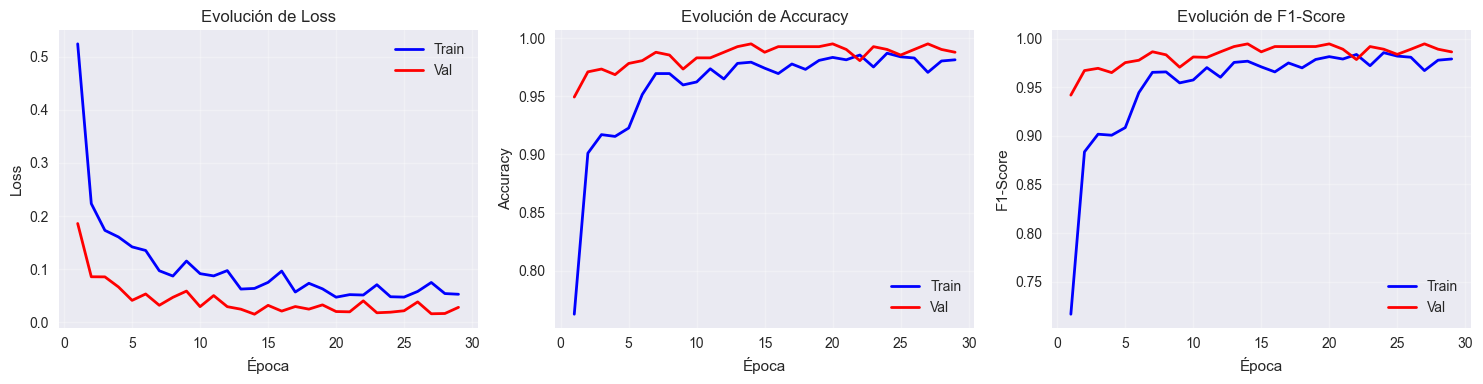


✅ Gráfica de progreso guardada en: results\cnn_no_da\training_progress.png


In [42]:
# ============================================================
# VISUALIZACIÓN: PROGRESO DE ENTRENAMIENTO
# ============================================================

print("\n" + "="*70)
print("📊 VISUALIZACIÓN")
print("="*70)

# Graficar progreso del entrenamiento
fig_progress = plot_training_history(
    history,
    save_path=save_dir / "training_progress.png"
)

print(f"\n✅ Gráfica de progreso guardada en: {save_dir / 'training_progress.png'}")


💾 Matriz guardada en: results\cnn_no_da\confusion_matrix_test.png


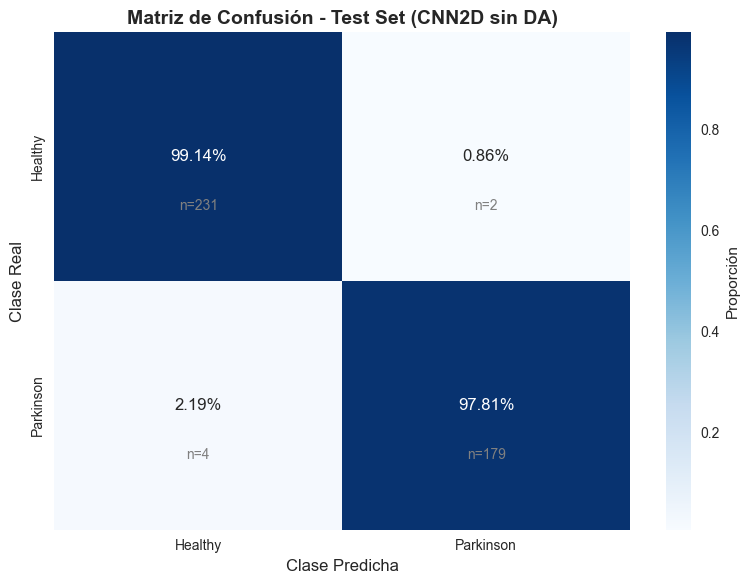


✅ Matriz de confusión guardada en: results\cnn_no_da\confusion_matrix_test.png


In [43]:
# ============================================================
# VISUALIZACIÓN: MATRIZ DE CONFUSIÓN
# ============================================================

cm = test_metrics["confusion_matrix"]

fig_cm = plot_confusion_matrix(
    cm,
    class_names=["Healthy", "Parkinson"],
    title="Matriz de Confusión - Test Set (CNN2D sin DA)",
    save_path=save_dir / "confusion_matrix_test.png",
    show=True
)

print(f"\n✅ Matriz de confusión guardada en: {save_dir / 'confusion_matrix_test.png'}")


## 📋 Resumen Final

### ✅ Completado:
1. **Datos**: Cargados desde cache (augmentados)
2. **Split**: Train/Val/Test estratificado (70/15/15)
3. **Modelo**: CNN2D con mismo backbone que CNN2D_DA (sin DA)
4. **Training**: Con early stopping
5. **Evaluation**: Métricas completas en test set
6. **Visualización**: Progreso y matriz de confusión

### 🏗️ Arquitectura:
- **Feature Extractor**: 2 bloques Conv2D → BN → ReLU → MaxPool(3×3) → Dropout (igual que CNN2D_DA)
- **Solo cabeza PD**: Sin Domain Adaptation (sin GRL ni cabeza de dominio)

### 📊 Resultados Guardados:
- Modelo: `results/cnn_no_da/best_model.pth`
- Métricas: `results/cnn_no_da/test_metrics.json`
- Gráficas: `results/cnn_no_da/training_progress.png`, `confusion_matrix_test.png`

### 🔄 Comparación con CNN2D_DA:
- **Este modelo**: Mismo backbone de Ibarra pero SIN Domain Adaptation
- **CNN2D_DA** (en `cnn_da_training.ipynb`): Mismo backbone CON DA (GRL + cabeza de dominio)
- **Ventaja**: Comparación justa usando idéntico Feature Extractor

### 🚀 Próximos Pasos (Futuro):
1. **MC Dropout**: Implementar inferencia con MC Dropout para cuantificar incertidumbre
2. **Comparación**: Comparar resultados entre CNN2D y CNN2D_DA con arquitecturas equivalentes
3. **MC Dropout en DA**: Aplicar MC Dropout también a CNN2D_DA


In [44]:
# ============================================================
# RESUMEN FINAL
# ============================================================

print("\n" + "="*70)
print("📋 RESUMEN FINAL")
print("="*70)

print(f"\n🎯 MODELO: CNN2D (sin Domain Adaptation)")
print(f"\n📊 DATASET:")
print(f"   • Total muestras: {len(X_combined)}")
print(f"   • Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

print(f"\n🏆 MEJOR MODELO (Época {best_epoch}):")
print(f"   • Val Loss: {best_val_loss:.4f}")

print(f"\n🎯 MÉTRICAS EN TEST SET:")
report = test_metrics["classification_report"]
print(f"   • Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"   • Precision: {report['macro avg']['precision']:.4f}")
print(f"   • Recall:    {report['macro avg']['recall']:.4f}")
print(f"   • F1-Score:  {test_metrics['f1_macro']:.4f}")

print(f"\n📁 Archivos guardados en: {save_dir}")
print(f"   ✓ best_model.pth")
print(f"   ✓ test_metrics.json")
print(f"   ✓ training_progress.png")
print(f"   ✓ confusion_matrix_test.png")

print("\n" + "="*70)
print("✅ PIPELINE COMPLETADO EXITOSAMENTE")
print("="*70)



📋 RESUMEN FINAL

🎯 MODELO: CNN2D (sin Domain Adaptation)

📊 DATASET:
   • Total muestras: 2772
   • Train: 1941 | Val: 415 | Test: 416

🏆 MEJOR MODELO (Época 14):
   • Val Loss: 0.0154

🎯 MÉTRICAS EN TEST SET:
   • Accuracy:  0.9856
   • Precision: 0.9860
   • Recall:    0.9848
   • F1-Score:  0.9853

📁 Archivos guardados en: results\cnn_no_da
   ✓ best_model.pth
   ✓ test_metrics.json
   ✓ training_progress.png
   ✓ confusion_matrix_test.png

✅ PIPELINE COMPLETADO EXITOSAMENTE
